<center>

---
```
🤖 IMPLEMENTAÇÃO DE REDES NEURAIS ARTIFICIAIS COM ARDUINO NANO BLE 33 PARA IDENTIFICAÇÃO DE GESTOS

```
---

O código a seguir demosntra como realizar a implementação de redes neurais artificiais no Microcontrolador Arduino Nano BLE 33
<br><br>**SÃO 4 TIPOS DE GESTOS :**
> 👊🏼 Soco
<br> 💪🏽 Flexão do braço
<br> 🤜🏾 Movimento para a Direita
<br> 🤛🏿 Movimento para a Esquerda

---

**OBS! : Essa etapa só é feita após o salvamento dos arquivos em .CSV através dos dados coletados do monitor serial da IDE do Arduino**


<br><font size = 5> 📚 Bibliotecas utilizadas

In [1]:
import os                                             # Bliblioteca para funções operacionais
import math                                           # Biblioteca com funções matemáticas
import numpy             as np                        # Biblioteca com funções matemáticas
import pandas            as pd                        # Biblioteca para manipulação e análise de dados
import pickle            as pic                       # Biblioteca para salvar e carregar dados
import matplotlib.pyplot as plt                       # Biblioteca com ferramentas de plotagem de gráficos

In [106]:
import tensorflow as tf                               # Importa tensorflow para aprendizado de máquina

from sklearn.metrics         import confusion_matrix  # Biblioteca para calcular a matriz de confusão
from sklearn.preprocessing   import MinMaxScaler      # Biblioteca para normalizar os dados
from sklearn.model_selection import train_test_split  # Biblioteca para dividir os dados em conjuntos de treinamento e teste

# <font size = 5> 👾 Funções Disponíveis

Normalizador dos valores do acelerômetro e do giroscópio

In [29]:
def normalizar_dados(df):

    df_norm = df.copy()

    # Normalização dos acelerômetros
    for col in ['aX', 'aY', 'aZ']:
        df_norm[col] = (df_norm[col] + 4.0) / 8.0

    # Normalização dos giroscópios
    for col in ['gX', 'gY', 'gZ']:
        df_norm[col] = (df_norm[col] + 2000.0) / 4000.0

    return df_norm

Função que recebe os dados e trata meus dados e classes para a DNN

In [4]:
def x_y_dnn(dataframe, OHE, divisao_dados):

    x , y = [] , []

    batch_size = divisao_dados

    for i, df in enumerate(dataframe):

        num_samples = df.shape[0] // batch_size
        saida = OHE[i]

        for j in range(num_samples):

            tensor = df[j * batch_size: (j + 1) * batch_size].flatten().tolist()

            x.append(tensor)
            y.append(saida.tolist())

    x = np.array(x)
    y = np.array(y)

    print(f"Entradas (X) shape: {x.shape}")
    print(f"Saídas   (Y) shape: {y.shape}")

    return x, y

Separa os dados para `treino`, `validação` e `teste`

In [5]:
def train_valid_test(X, Y, div_treino, div_valida, div_testes):

  X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size = (div_valida + div_testes), shuffle=True)

  taxa_valid = div_valida / (div_testes + div_valida)

  X_test, X_validate, y_test, y_validate = train_test_split(X_temp, y_temp, test_size = taxa_valid, shuffle=True)

  print(f"Shape dos dados de treinamento: {X_train.shape}")
  print(f"Shape dos dados de validação:   {X_validate.shape}")
  print(f"Shape dos dados de teste:       {X_test.shape}")

  return X_train, X_validate, X_test, y_train, y_validate, y_test

Função para avaliar o meu modelo depois do treinamento

In [6]:
def evaluate_model(model, dataset_test):

  teste_loss, teste_accuracy, teste_precision, teste_recall = model.evaluate(dataset_test)

  classes_CNN = ['Loss', 'Acurácia', 'Precisão', 'Recall']
  indices_CNN = ['Valor']

  loss_CNN      = np.around(teste_loss,      2)
  acuracia_CNN  = np.around(100 * teste_accuracy,  2)
  precision_CNN = np.around(100 * teste_precision, 2)
  recall_CNN    = np.around(100 * teste_recall,    2)

  dados_tab_CNN = [[loss_CNN, acuracia_CNN, precision_CNN, recall_CNN]]

  tabela_CNN = pd.DataFrame(dados_tab_CNN, index = indices_CNN, columns = classes_CNN)

  print('\n')
  display(tabela_CNN)

Cria dataset, seja para `treino`, `teste` ou `validação`

In [7]:
def create_dataset(X, y, batch_size):

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)
    return dataset

Plota o resultado do modelo treinado

In [8]:
def plot_model(accuracy, val_accuracy, loss, val_loss, epochs, metrica_1, metrica_2):

    epochs_range = range(epochs)

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title(f'Training and Validation {metrica_1}')
    plt.plot(epochs_range, accuracy, label=f'Training {metrica_1}')
    plt.plot(epochs_range, val_accuracy, label=f'Validation {metrica_1}')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.title(f'Training and Validation {metrica_2}')
    plt.plot(epochs_range, loss, label = f'Training {metrica_2}')
    plt.plot(epochs_range, val_loss, label = f'Validation {metrica_2}')
    plt.legend(loc='lower right')

    plt.show()

Cria a matriz de confusão com base nos resultados e número de classes

In [9]:
def matriz_confusao(y_true, y_pred, classes):

  cm = confusion_matrix(y_true, y_pred)

  # Define as classes do modelo
  classes_ = classes

  # Cria a figura e o eixo da matriz de confusão
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)

  # Adiciona os rótulos dos eixos
  ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes_, yticklabels=classes_,
        ylabel='Verdadeiro',
        xlabel='Previsto')

  # Adiciona as anotações dos valores na matriz
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], 'd'),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")

  plt.title("Matriz de Confusão")
  plt.show()

# <t>

# <font size = 5> 💾 Salvamento dos dados nas variáveis respectivas

>**OBS:** É preciso importar manualmente na aba lateral esquerda os arquivos `.csv` clicando no ícone de pasta e de upload

Armazena os dados em cada variável

In [10]:
path_soco     = "/content/soco_100.csv"
path_flexao   = "/content/flexao_100.csv"
path_direita  = "/content/direita_100.csv"
path_esquerda = "/content/esquerda_100.csv"

Leitura de um dos arquivos e display para mostrar um exemplo do formato dos dados

In [168]:
dt_soco = pd.read_csv(path_soco).dropna()

display(dt_soco)

,aX,aY,aZ,gX,gY,gZ
0,-0.126,-1.446,1.995,-46.143,66.223,-18.066
1,-0.225,-1.556,2.047,-39.856,75.745,-34.607
2,-0.326,-1.629,2.056,-24.963,90.637,-53.894
3,-0.344,-1.645,2.002,-7.507,107.117,-70.557
4,-0.265,-1.588,1.873,5.310,117.676,-81.299
...,...,...,...,...,...,...
9995,-0.153,0.382,0.906,-10.498,2.808,-0.305
9996,-0.159,0.381,0.913,-9.460,-0.183,1.343
9997,-0.155,0.378,0.907,-6.470,-1.770,2.136
9998,-0.148,0.392,0.889,-3.174,-1.587,2.136


Normalização dos dados do acelerômetro e do giroscópio

In [169]:
dt_soco_norm = normalizar_dados(dt_soco)

display(dt_soco_norm)

,aX,aY,aZ,gX,gY,gZ
0,0.484250,0.319250,0.749375,0.488464,0.516556,0.495483
1,0.471875,0.305500,0.755875,0.490036,0.518936,0.491348
2,0.459250,0.296375,0.757000,0.493759,0.522659,0.486526
3,0.457000,0.294375,0.750250,0.498123,0.526779,0.482361
4,0.466875,0.301500,0.734125,0.501328,0.529419,0.479675
...,...,...,...,...,...,...
9995,0.480875,0.547750,0.613250,0.497375,0.500702,0.499924
9996,0.480125,0.547625,0.614125,0.497635,0.499954,0.500336
9997,0.480625,0.547250,0.613375,0.498383,0.499557,0.500534
9998,0.481500,0.549000,0.611125,0.499206,0.499603,0.500534


Salvamento do restante dos dados em suas respectivas variáveis, além de retirar dados vazios com a função `.dropna()`

In [170]:
dt_flexao   = pd.read_csv(path_flexao).dropna()
dt_direita  = pd.read_csv(path_direita).dropna()
dt_esquerda = pd.read_csv(path_esquerda).dropna()

Armazena o nome de cada coluna

In [171]:
cols_df = []

[cols_df.append(dt_soco.columns[i]) for i in range(len(dt_soco.columns))]

cols_df

['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']

Salva todos os dados em uma única lista

In [172]:
dfs = [dt_soco, dt_flexao, dt_direita, dt_esquerda]

Cria uma lista com todos os dados normalizados

In [173]:
dfs_norm = []

for i in range(len(dfs)): dfs_norm.append(normalizar_dados(dfs[i]))

In [174]:
for i in range(len(dfs_norm)): dfs_norm[i] = np.array(dfs_norm[i])

Printa o formato dos dados finais

> No caso são `4` listas com `10000` linhas e `6` colunas, formando o shape `(4, 10000, 6)`

In [175]:
np.array(dfs).shape, np.array(dfs_norm).shape

((4, 10000, 6), (4, 10000, 6))

# <t>

# <font size = 5> 📈 Plot dos gráficos de acelerômetro e giroscópio **(OPICIONAL)**

Define qual dos dados deseja-se plotar, depois basta rodar os códigos debaixo

In [67]:
dado_plot = dt_flexao
tipo_plot = 'Soco'

Printa os dados das três primeiras colunas, definido pelo código `[:3]`

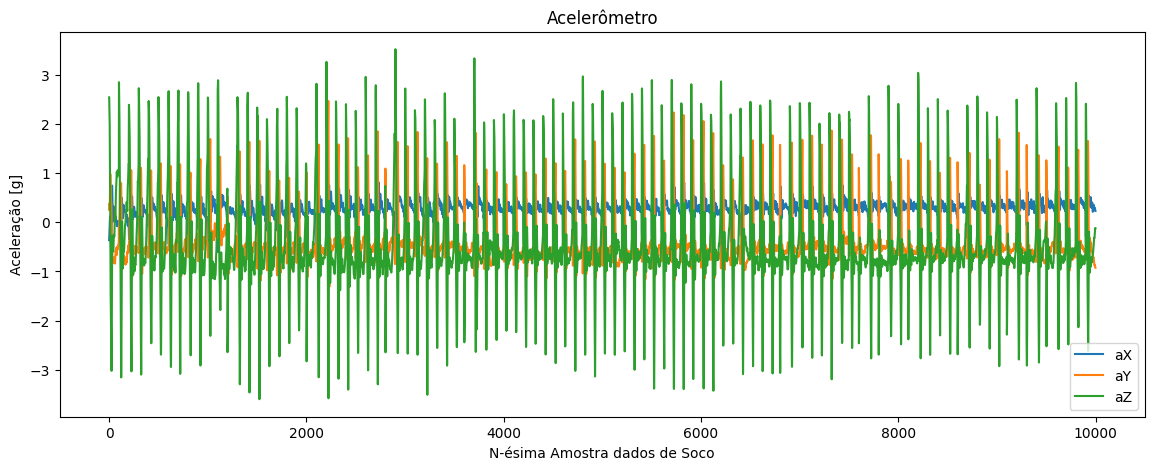

In [68]:
plt.rcParams["figure.figsize"] = (14,5)

for i in range(len(dado_plot.columns[:3])):

  plt.plot(list(range(len(dado_plot[dado_plot.columns[:3][i]]))), dado_plot[dado_plot.columns[:3][i]], label = dado_plot.columns[:3][i])

plt.title("Acelerômetro")
plt.xlabel(f"N-ésima Amostra dados de {tipo_plot}")
plt.ylabel("Aceleração [g]")

plt.legend()
plt.show()

Printa os dados das três primeiras colunas, definido pelo código `[3:]`

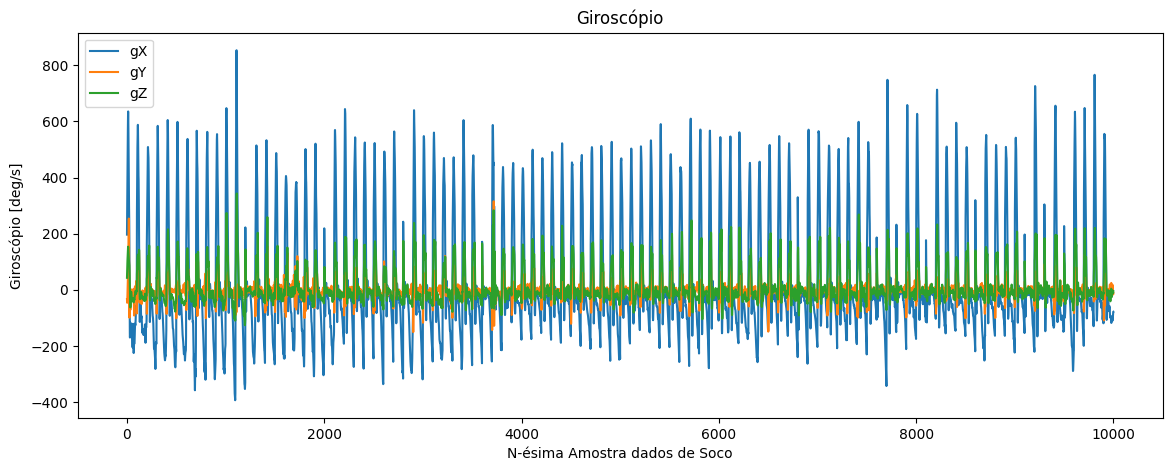

In [69]:
plt.rcParams["figure.figsize"] = (14,5)

for i in range(len(dado_plot.columns[3:])):

  plt.plot(list(range(len(dado_plot[dado_plot.columns[3:][i]]))), dado_plot[dado_plot.columns[3:][i]], label = dado_plot.columns[3:][i])

plt.title("Giroscópio")
plt.xlabel(f"N-ésima Amostra dados de {tipo_plot}")
plt.ylabel("Giroscópio [deg/s]")

plt.legend()
plt.show()

# <font size = 5> 💻 Etapas para gerar dados e modelo `Dense Neural Network (DNN)`

#####<font size = 4>Preparo dos dados e datasets

Aplica o `One-Hot-Encoded (OHE)` na variável que recebe o nome de cada gesto e printa a matriz com os zeros e uns

In [176]:
gestos = ['Soco', 'Flexao', 'Direita', 'Esquerda']

OHE_gestos = np.eye(len(gestos))

print(OHE_gestos)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Define a quantidade de dados por vetor que será usado nos treinamentos

In [177]:
batch_size = 50

Percorre os dfs e a matriz OHE e gera os dados de entrada `X` e de saída `Y`

In [178]:
x_dnn, y_dnn = x_y_dnn(dfs_norm, OHE_gestos, batch_size)

Entradas (X) shape: (800, 300)
Saídas   (Y) shape: (800, 4)


Separa para cada dataset uma porcentagem dos `20000` dados

In [179]:
div_treino = 0.70
div_valida = 0.20
div_testes = 0.10

Faz toda a divisão dos dados para `Treino`, `Teste` e `Validação`

In [180]:
X_train_norm_DNN, X_validate_norm_DNN, X_test_norm_DNN, y_train_norm_DNN, y_validate_norm_DNN, y_test_norm_DNN = train_valid_test( x_dnn,
                                                                                                                                   y_dnn,
                                                                                                                                   div_treino,
                                                                                                                                   div_valida,
                                                                                                                                   div_testes )

Shape dos dados de treinamento: (559, 300)
Shape dos dados de validação:   (161, 300)
Shape dos dados de teste:       (80, 300)


Chama a função `create_dataset` e armazena o dataset de cada etapa

In [181]:
dst_train_norm_DNN = create_dataset(X_train_norm_DNN,    y_train_norm_DNN,    batch_size)
dst_valid_norm_DNN = create_dataset(X_validate_norm_DNN, y_validate_norm_DNN, batch_size)
dst_teste_norm_DNN = create_dataset(X_test_norm_DNN,     y_test_norm_DNN,     batch_size)

Define a quantidade de épocas de treinamento e a taxa de aprendizado (*learning rate*)

In [182]:
epocas = 200
taxa_aprendizado = 0.001

#####<font size = 4>Criação, treinamento e teste do modelo DNN

In [183]:
DNN_model = tf.keras.models.Sequential([

    tf.keras.layers.InputLayer(shape = (X_train_norm_DNN.shape[1],)),

    # Construção das camadas densas com seus respectivos neurônios
    tf.keras.layers.Dense(64, activation = 'relu'),

    # Camada de saída
    tf.keras.layers.Dense(len(OHE_gestos), activation = 'softmax')

])

DNN_model.compile(

    optimizer = tf.keras.optimizers.Adam(learning_rate = taxa_aprendizado),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'precision', 'recall']

)

DNN_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,524 (76.27 KB)

 Trainable params: 19,524 (76.27 KB)

 Non-trainable params: 0 (0.00 B)

In [184]:
history_DNN = DNN_model.fit(

    dst_train_norm_DNN,
    validation_data = dst_valid_norm_DNN,
    epochs = epocas

)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3236 - loss: 1.4160 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2484 - val_loss: 1.3417 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3767 - loss: 1.3249 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3292 - val_loss: 1.2820 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3801 - loss: 1.2863 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5093 - val_loss: 1.2218 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5051 - loss: 1.2412 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6273 - val_loss: 1.1377 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 1.1570 - precision: 0

Faz uma avaliação do modelo com dados de teste

In [185]:
evaluate_model(DNN_model, dst_teste_norm_DNN)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9767 - loss: 0.1421 - precision: 0.9915 - recall: 0.9683




,Loss,Acurácia,Precisão,Recall
Valor,0.15,97.5,98.72,96.25


Teste de fato com os dados de teste e obtém os valores `previstos`e `esperados`

In [187]:
predictions = DNN_model.predict(X_test_norm_DNN)
predictions = np.argmax(predictions, axis=1)

esperado = np.argmax(y_test_norm_DNN, axis=1)

incremento = 0
previsao   = predictions

for i in range(len(previsao)):
  if previsao[i] == esperado[i]:
    incremento = incremento + 1

print('\nResultados Esperados: %s' % esperado)
print('\nResultados Previstos: %s' % predictions)
print('\nTeste teve {}% de aproveitamento\n'.format(round((incremento/len(previsao))*100,2)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Resultados Esperados: [3 1 2 1 2 2 2 1 3 3 2 0 2 1 2 2 0 3 2 2 3 2 3 2 0 2 0 3 1 1 0 3 2 2 0 1 1
 0 1 3 3 2 0 2 0 1 0 2 2 2 3 1 0 3 2 1 2 2 2 1 1 1 0 0 0 3 3 3 3 3 2 2 3 0
 3 0 2 1 3 1]

Resultados Previstos: [3 1 2 1 2 2 2 1 3 3 2 0 2 1 0 2 0 3 2 2 3 2 3 2 0 2 0 3 1 1 0 3 2 2 0 1 1
 0 1 3 3 2 0 2 0 1 0 2 2 2 3 1 0 3 2 1 2 2 2 1 1 1 0 0 0 3 3 3 3 3 2 2 3 0
 3 0 2 1 0 1]

Teste teve 97.5% de aproveitamento



#####<font size = 4>Avaliações do modelo

Armazena nas variáveis as `acurácias` e `losses` de treino e validação

In [188]:
acuracia_treino = history_DNN.history['accuracy']
acuracia_valida = history_DNN.history['val_accuracy']

loss_treino = history_DNN.history['loss']
loss_valida = history_DNN.history['val_loss']

precisao_treino = history_DNN.history['precision']
precisao_valida = history_DNN.history['val_precision']

recall_treino = history_DNN.history['recall']
recall_valida = history_DNN.history['val_recall']

Plot do aprendizado do modelo

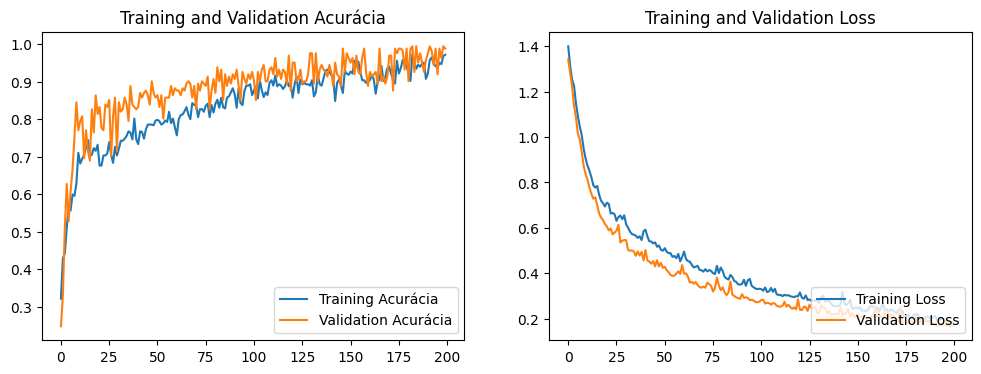

In [189]:
plot_model(acuracia_treino, acuracia_valida, loss_treino, loss_valida, epocas, 'Acurácia', 'Loss')

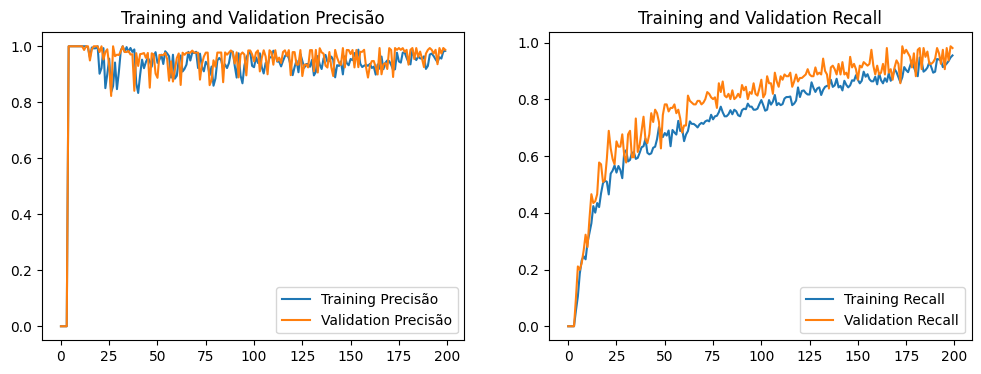

In [190]:
plot_model(precisao_treino, precisao_valida, recall_treino, recall_valida, epocas, 'Precisão', 'Recall')

Matriz de confusão para os resultados obtidos

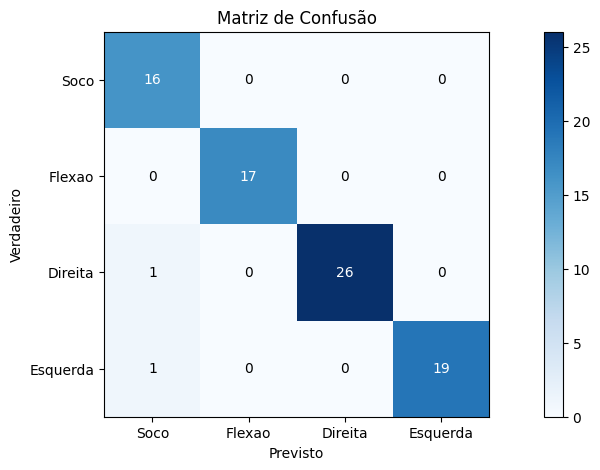

In [191]:
matriz_confusao(esperado, previsao, gestos)

#####<font size = 4> Converte o modelo treinado em <font size = 5>`DNN_model.h`

In [192]:
nome_modelo = 'DNN_model'
data_modelo =  DNN_model

In [193]:
converter = tf.lite.TFLiteConverter.from_keras_model(data_modelo)
tflite_model = converter.convert()

open("gesture_model.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmpp3c4_d65'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300), dtype=tf.float32, name='keras_tensor_36')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138955219457360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955219457552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955173420624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138955173421008: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 79840 bytes


In [194]:
!echo "const unsigned char model[] = {" > /content/DNN_model.h
!cat gesture_model.tflite | xxd -i      >> /content/DNN_model.h
!echo "};"                              >> /content/DNN_model.h

data_modelo_size = os.path.getsize(f"{nome_modelo}.h")
print(f"Header file, {nome_modelo}.h, is {data_modelo_size:,} bytes.")
print(f"\nOpen the side panel (refresh if needed). Double click {nome_modelo}.h to download the file.")

Header file, DNN_model.h, is 492,382 bytes.

Open the side panel (refresh if needed). Double click DNN_model.h to download the file.
